# FIT5149 S1 2020 Assessment 2: Authorship Profiling

## Text Preprocessing and Feature Extraction

Student information
- Group: 41
- Student Names: Alan Gewerc, Cristiana Garcia Gewerc, Priscila Grecov
- Student ID: 2996246, 3008887, 29880858
- Student email: agew0001@student.monash.edu, ccal0007@student.monash.edu, pgre0007@student.monash.edu

Programming Language: Python 3 in Jupyter Notebook

Libraries used:
- bs4
- re
- os
- numpy
- pandas
- matplotlib
- itertools
- nltk.tokenize.casual
- nltk.probability
- sklearn.feature_extraction.text
- time
- gensim.models 
- pprint
- scipy.sparse
- random
- warnings

### 0. Import Libraries

In [1]:
from bs4 import BeautifulSoup as bsoup # pulling data out of HTML and XML files
import re # regex - string manipulation
from nltk.tokenize.casual import TweetTokenizer # for tokenization
import os # file manipulation
import numpy as np # work with arrays
import pandas as pd # for dataframes
import random 
import warnings
import matplotlib.pyplot as plt
from itertools import chain # iterators for efficient looping
from nltk.probability import * # statistical natural language processing
from sklearn.feature_extraction.text import CountVectorizer # bag of words
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf
from time import time # to track performance
from gensim.models import Word2Vec # for embedding
from pprint import pprint
from scipy.sparse import csr_matrix

### 1. Function for Parsing Data

The data comes in data.zip contains 3,600 twitter texts for those authors, which acts as the training and testing
data. We have unzipped the folder and we need to extract the labels and text from each one of the 3,600 .XML files. Each file contains 100 tweets associated to the same person. The `read_xml` function take the path where the .XML files are located and returns a list of the parsed contents. 

In [2]:
def read_XML (file_path):
    """
        This function extracts the posts from XML file and returns a list of the posts delimited by <document> tag.
    """    
    infile = open(file_path,"r", encoding = "UTF-8")
    contents = infile.read()
    soup = bsoup(contents,'xml')
    posts = soup.find_all('document')

    post_list = []
    for i in range(0, len(posts)):
        post_list.append(posts[i].get_text())
    
    return post_list

To retrieve the matching IDs of each element of the list returned by the `read_XML()`, we construct a dictionary where the keys are the file name corresponding to the extracted text which is the value.

In [3]:
dict_posts = {} # dict with ID and text posts

xml_file_path = "data/" # relative path to get files from

for xfile in os.listdir(xml_file_path): 

    xfile = os.path.join(xml_file_path, xfile) # joining file ID and contents

    if os.path.isfile(xfile) and xfile.endswith('.xml'): # going tweet by tweet for the person 
        post = read_XML(xfile)
        post_id = re.sub("data/", "" ,xfile)
        post_id = re.sub(".xml", "" ,post_id)
        dict_posts[post_id] = post

### 2. Make Tokenization and Create Features

Now `dict_posts` is a dictionary where each key is a unique user ID and each value is a list of the corresponding user posts. We create the `TokenizeReplaceURL` function to perform the following steps:

1. Lowercase all words;
2. Aggregate for each user all posts and make it into a single block of posts;
3. Replace all URL links by the string `URL` (using the regex pattern suggested by Cham J. (2013, March 15));
4. Replace all @username kind of mentions by `xusernamex`;
5. Tokenize the blocks of posts using `TweetTokenizer` as described in NLTK Project. (2020);
6. Remove all words that contain digits by selecting words only if all characters in the string are alphabetic.

The idea of aggregating usernames and URLs into one varible was taken from Nieuwenhuis, M., & Wilkens, J. (2018, September). The authors show that in a similar classification task, adding these 2 steps increases the accuracy of the models.

In [4]:
TweetToken = TweetTokenizer()

def TokenizeReplaceUserURL(k, v, tknzr = TweetToken):
    """
        This function replace @username by xxusername and URLs and tokenizes a raw text document.
    """
    raw_article = ' '.join(v).lower() # cover all words to lowercase
    replaced_article = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
, 'URL', raw_article, flags=re.MULTILINE)
    tokenised_article = re.sub(r'(\@\w+)', 'xusernamex', replaced_article)
    tokenised_article = tknzr.tokenize(tokenised_article) # tokenize
    tokenised_article = [word for word in tokenised_article if word.isalpha()]  # remove all words that contain digits
   
    return (k, tokenised_article)     

In [5]:
# takes a while to run 
dict_token_by_id = dict(TokenizeReplaceUserURL(k, v) for k, v in dict_posts.items())

After implementing the preprocessing to generate `dict_token_by_id` (a dictionary of IDs and lists of corresponding preprocessed tokens), lets analyse our vocabulary with some metrics such as lexical diversity:

$Lexical Diversity = \frac{Number of Unique Words}{Number of Tokens}$


In [6]:
# implementing the Lexical Diversity formula
words = list(chain.from_iterable(dict_token_by_id.values()))
vocab = set(words)
lexical_diversity = len(vocab)/len(words)
print ("Vocabulary size: ",len(vocab),"\nTotal number of tokens: ", len(words), \
"\nLexical diversity: ", lexical_diversity)

Vocabulary size:  90321 
Total number of tokens:  4603407 
Lexical diversity:  0.019620468057679887


### 3. Train Labels 

We retrive the train labels from `train_labels.csv` file. The tweets in `dict_token_by_id` contains a mix of training and testing IDs. To separate it in the future, we will need the information contained in the id column of the `train_labels` dataframe.

In [7]:
# loading the dataset
train_labels = pd.read_csv('train_labels.csv', index_col='id') 
train_labels.head()

,gender
id,
b91efc94c91ad3f882a612ae2682af17,male
ff91e6d4b79fc64072ae273aa3fed77e,male
7e199c5885131a2579429c07f3215cbc,female
cdc2d20d75f8187ee54caf56b2c77626,male
53259762a49f56f451605df3efa955e6,female


### 4. Analysis of Most and Less Frequent Words

In [8]:
# getting the word frequency
fd_1 = FreqDist(words)

We use the `most_common` function to print out the most frequent words together with their frequencies.

In [9]:
print(fd_1.most_common(25))

[('xusernamex', 272010), ('URL', 168805), ('the', 151927), ('to', 116209), ('a', 97881), ('i', 73395), ('of', 68470), ('and', 65327), ('in', 62509), ('for', 58422), ('is', 57648), ('you', 56360), ('on', 42992), ('it', 40450), ('this', 38605), ('that', 32309), ('my', 31946), ('with', 27124), ('be', 26277), ('at', 22617), ('have', 22405), ('so', 22214), ('are', 22178), ('not', 21579), ('your', 20744)]


The list above contains the 25 most frequent words. You can see that it is mostly dominated by the little words of the English language which have important grammatical roles. Those words are articles, prepositions, pronouns, auxiliary webs, conjunctions, etc. 

Also, our designed words `xusernamex` and `URL` are the top most common words. It means that users mention a lot other users and websites. 

In a first step, we don't remove this words because maybe men and women uses than with a different frequency. For instance, we have a hypothesis that women talk about themselves more than men, so `I` could offer some differentiation power between the two groups. 

What proportion of the text is taken up with such words? We generate a cumulative frequency plot for them using  `fd.plot(25, cumulative=True)`. These 25 words account for about 16% of the total tweets corpus.

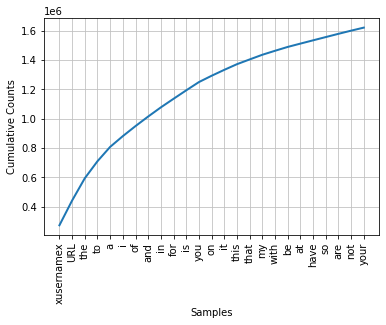

In [9]:
# plotting the cumulative frequency 
%matplotlib inline
fd_1.plot(25, cumulative=True)

Now we look at the word's frequency in terms of how many documents they appear at:

In [10]:
words_2 = list(chain.from_iterable([set(value) for value in dict_token_by_id.values()]))
fd_2 = FreqDist(words_2)
print(fd_2.most_common(25))

[('to', 3591), ('a', 3590), ('the', 3589), ('for', 3585), ('in', 3583), ('of', 3579), ('on', 3578), ('and', 3577), ('is', 3566), ('URL', 3562), ('with', 3556), ('you', 3545), ('it', 3540), ('this', 3517), ('be', 3515), ('that', 3514), ('are', 3507), ('i', 3499), ('at', 3495), ('xusernamex', 3483), ('have', 3472), ('not', 3438), ('from', 3429), ('what', 3426), ('all', 3403)]


The words are still similar, but the order of the most common ones is a bit different. For instance, `URL` doesn't show up in `fd_2`, meaning that probabibly it's not so many users that cite websites but some of the users who do it use a lot of citations.

### 5. Filtering Rare Tokens

We do two different kinds of fiters here:

1. `more_than_1doc`: only removes the tokens which are used by a single user;
2. `more_than_5perc`: removes the tokens which are used by less than 5% of the users.

In [11]:
more_than_1doc = [i[0] for i in fd_2.items() if i[1] >= 2] # list of words which more than 1 person uses
more_than_5perc = [i[0] for i in fd_2.items() if i[1] >= 180] # list of words which more than 5% of people uses

len(more_than_1doc) # remaining vocabulary size after "more than 1-person" filter

44639

In [12]:
len(more_than_5perc) # remaining vocabulary size after "more than 5%-people" filter

1849

Based on this filtered vocabularies, we generate `tokenized_id` (with the 1 user filter) and `tokenized_id2` (with the 5% of users filter).

In [13]:
tokenized_id = {} # dictionary of tokens considering only tokens appering in more than 1 user
tokenized_id2 = {} # dictionary of tokens considering only tokens appering in more than 5% of users

for user in dict_token_by_id:
    # the first version is for bag of words
    tokenized_id[user] = [w for w in dict_token_by_id[user] if w in more_than_1doc]
    # the second version is for tf-idf and word2vec
    tokenized_id2[user] = [w for w in dict_token_by_id[user] if w in more_than_5perc]

Let's generate the tokens list and frequency of words of each of this dictionaries to compare the distribution of frequencies:

In [14]:
words_3 = list(chain.from_iterable(tokenized_id.values()))
fd_3 = FreqDist(words_3)
fd_3b = FreqDist(list(chain.from_iterable(tokenized_id2.values())))

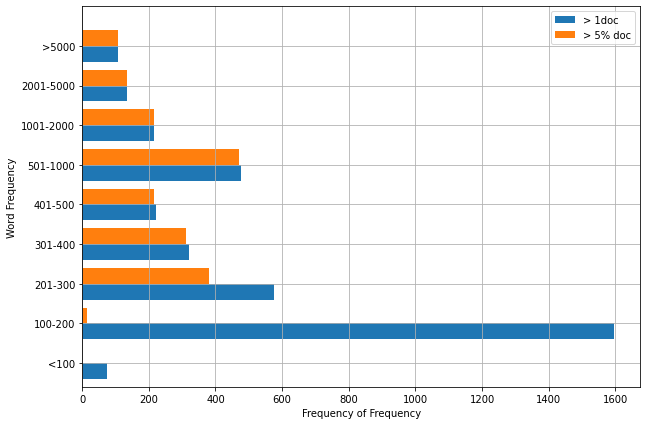

In [15]:
# plotting the graph to see the different frequency distribution of words for the both filters
ind = np.arange(9)
width = 0.2
label_graph = ['> 1doc', '> 5% doc']

fig, ax = plt.subplots(figsize=(10,7))
i = 0
for freq_d in [fd_3, fd_3b]:
    ffd = FreqDist(freq_d.values())
    from pylab import *
    y = [0]*9
    for k, v in ffd.items():
         if k <= 100:
            y[0] = v
         elif k >100 and k <= 200:
            y[1] =  y[1] + v
         elif k >200 and k <= 300:
            y[2] =  y[2] + v
         elif k > 300 and k <= 400:
            y[3] =  y[3] + v
         elif k > 400 and k <= 500:
            y[4] =  y[4] + v
         elif k > 500 and k <= 1000:
            y[5] =  y[5] + v
         elif k > 1000 and k <= 2000:
            y[6] =  y[6] + v
         elif k > 2000 and k <= 5000:
            y[7] =  y[7] + v
         else:
            y[8] =  y[8] + v
    x = range(0,9) # generate integer from 1 to 8
    ytks =list(map(str, ['<100', '100-200','201-300','301-400','401-500','501-1000','1001-2000',
                     '2001-5000','>5000'])) # covert a integer list to a string list
    ax.barh(ind - width+ 2*i*width, y, align='center', height=0.4, label=label_graph[i])
    yticks(x, ytks)
    xlabel('Frequency of Frequency')
    ylabel('Word Frequency')
    grid(True)
    i=+1
ax.set(yticks=ind, yticklabels = ytks, ylim=[2*width-1, 9])
ax.legend()
plt.show()

As expected, the dictionary where we filter out everything that appears in less than 5% of the user tweet blocks has no words which repeats themselfs less than 100 times and very few with a frequency smaller than 200. For the most frequent words the frequencies are very similar in both documents because those words are likely not to be filtered out for any of the filters.

In [16]:
vocab = set(words_3)
lexical_diversity = len(vocab)/len(words_3)
print ("Vocabulary size: ",len(vocab),"\nTotal number of tokens: ", len(words_3), \
"\nLexical diversity: ", lexical_diversity)

Vocabulary size:  44639 
Total number of tokens:  4549752 
Lexical diversity:  0.009811304000745535


### 6. Eliminate most common words for both men and women
    As we are interested in keeping in our vocabulary the words that might help distinguish if a writer is a man or a woman, instead of eliminating the most common words, we eliminate only the ones that are common for both men and women. 

    To accomplish such task, we calculate the difference of percentage of occurence of words between men and women. We check the intersection between the male and female sets of words and only eliminate the words which belong to this intersection and have a small percentage difference in the relative occurence for genders, and at the same time are between the 10% most common words.

In [17]:
# create a list for male vocabulary and another list for female vocabulary
male_words_list, female_words_list = [], []
for k, v in tokenized_id.items(): # must be in the training dataset
    if k in train_labels.index:
        if train_labels.loc[k,'gender'] == 'male':
            male_words_list.append(v) 
        if train_labels.loc[k,'gender'] == 'female':
            female_words_list.append(v)

In [18]:
# analysing the results
male_words, female_words = list(chain.from_iterable(male_words_list)), list(chain.from_iterable(female_words_list))
male_vocab, female_vocab = set(male_words), set(female_words)
female_lexical_diversity, male_lexical_diversity = len(male_vocab)/len(male_words), len(female_vocab)/len(female_words)
print ("Male Vocabulary size: ",len(male_vocab),"\nMale Total number of tokens: ", len(male_words), \
"\nMale Lexical diversity: ", male_lexical_diversity)
print ("Female Vocabulary size: ",len(female_vocab),"\nFemale Total number of tokens: ", len(female_words), \
"\nFemale Lexical diversity: ", female_lexical_diversity)

Male Vocabulary size:  39815 
Male Total number of tokens:  1988836 
Male Lexical diversity:  0.019456513612082643
Female Vocabulary size:  37472 
Female Total number of tokens:  1925936 
Female Lexical diversity:  0.020019247439205645


In terms of vocabulary size, lexical diversity and total number of tokens, men and women are very similar. Let's check the most frequent word occurences:

In [19]:
# total of each word in all posts
fd_1_m, fd_1_f = FreqDist(male_words), FreqDist(female_words)
%matplotlib inline
print("MALE:\n", fd_1_m.most_common(25))
print("FEMALE:\n", fd_1_f.most_common(25))

MALE:
 [('xusernamex', 123844), ('the', 72256), ('URL', 71391), ('to', 49518), ('a', 44060), ('of', 31244), ('in', 27912), ('i', 27683), ('and', 27624), ('is', 25537), ('for', 23855), ('you', 21637), ('on', 19561), ('it', 17761), ('this', 15690), ('that', 15142), ('with', 11902), ('be', 11632), ('my', 10543), ('at', 10132), ('not', 9854), ('have', 9398), ('are', 9245), ('but', 8863), ('from', 8185)]
FEMALE:
 [('xusernamex', 109081), ('URL', 73994), ('the', 58857), ('to', 50395), ('a', 40100), ('i', 35800), ('and', 28588), ('of', 27423), ('you', 27188), ('for', 26500), ('in', 25728), ('is', 24077), ('this', 17489), ('on', 17192), ('my', 17111), ('it', 17078), ('that', 12768), ('so', 11580), ('with', 11453), ('be', 11022), ('your', 10164), ('me', 9957), ('have', 9867), ('are', 9828), ('at', 9293)]


    We are not removing stopwords now, because women may use some stopwords more frequently than men and vice-versa. For instance, we had a hypothesis that women talk about themselves more often than men. In that case, words such as "I" and "my" would be more frequent in women's texts than men's. 
    
    We can see this hypothesis proved true as "I" appears 27683 for male and 35800 for female. This is a huge relative difference as the total number of tokens for both genders is almost the same.

In [20]:
# total of posts where each word appears
words_2_m = chain.from_iterable([set(value) for value in male_words_list]) 
words_2_f = chain.from_iterable([set(value) for value in female_words_list])
fd_2_m, fd_2_f = FreqDist(words_2_m), FreqDist(words_2_f)
print("MALE:\n", fd_2_m.most_common(25))
print("FEMALE:\n", fd_2_f.most_common(25))

MALE:
 [('on', 1548), ('the', 1548), ('to', 1548), ('a', 1547), ('for', 1546), ('in', 1546), ('and', 1545), ('of', 1543), ('URL', 1534), ('is', 1534), ('with', 1534), ('you', 1527), ('it', 1523), ('that', 1521), ('be', 1519), ('this', 1519), ('xusernamex', 1512), ('are', 1511), ('i', 1507), ('at', 1506), ('from', 1500), ('have', 1496), ('not', 1495), ('what', 1488), ('all', 1479)]
FEMALE:
 [('to', 1545), ('the', 1543), ('a', 1543), ('for', 1541), ('in', 1540), ('of', 1540), ('is', 1537), ('and', 1537), ('URL', 1534), ('on', 1533), ('with', 1531), ('you', 1529), ('it', 1525), ('this', 1511), ('be', 1509), ('that', 1508), ('are', 1508), ('at', 1507), ('i', 1504), ('have', 1502), ('xusernamex', 1484), ('not', 1469), ('my', 1466), ('so', 1465), ('what', 1465)]


Let's create a list of words to be removed based on the following rule:

If the word over the total number of tokens for men differs in less than a threshold of word over the total number of tokens for women it means that they use the word with about the same frequency and so the word is not helpful to distinguish between male/female.

We will define this threshold as the 50% quantile of the differences between %occurence of words.

In [21]:
def vocab_percentage(freq_dist_object):
    """
        This function returns the frequency of words in terms of token percentages.
    """
    vocab_size = len(freq_dist_object.keys())
    vocab_10perc = int(round(vocab_size/10,0)) # just look for 10% most common words
    words_10perc = freq_dist_object.most_common(vocab_10perc)
    dictionary = {x[0]:(x[1] / freq_dist_object.N())*100 for x in words_10perc}
    return (dictionary) 

In [22]:
# applying the function above to calculate the relative frequency by gender
male_percentages = vocab_percentage(fd_1_m)
female_percentages =vocab_percentage(fd_1_f)
# words in common:
keys_f = set(female_percentages.keys())
keys_m = set(male_percentages.keys())
intersection = keys_m & keys_f
# diff in percentage of words used by both male and female:
percentage_diff = {key: abs(male_percentages[key] - female_percentages[key]) for key in intersection}
print("The maximum diff in terms of percentages of occurences is: ", max(percentage_diff.values()),
     "\nThe median diff in terms of percentages of occurences is: ", np.quantile(list(percentage_diff.values()), 0.5))

The maximum diff in terms of percentages of occurences is:  0.5770592986091096 
The median diff in terms of percentages of occurences is:  0.00139761495921649


In [23]:
# seeing the results in term of common words with more potential to differentiate
{k: v for k, v in sorted(percentage_diff.items(), key=lambda item: item[1],reverse=True)}

{'the': 0.5770592986091096,
 'xusernamex': 0.5631673566335405,
 'i': 0.4669167349601173,
 'my': 0.35834205312581235,
 'you': 0.323754446241,
 'URL': 0.2523889823030623,
 'so': 0.21852965090615423,
 'for': 0.17650903747673707,
 'me': 0.1714163505382194,
 'more': 0.16647015260087172,
 'of': 0.1470900593155473,
 'your': 0.14465499389654424,
 'a': 0.1332616803759099,
 'to': 0.1268517217169931,
 'this': 0.1191742821301206,
 'love': 0.11833411094941532,
 'that': 0.09839947647659075,
 'and': 0.09541602227697443,
 'thank': 0.09223437546634729,
 'on': 0.09088325177571821,
 'today': 0.08558122176539429,
 'day': 0.06963325798217734,
 'am': 0.06868363003700619,
 'in': 0.06756403296210545,
 'trump': 0.06591615001646789,
 'from': 0.06319715584945368,
 'he': 0.05601711269607623,
 'game': 0.054993911091591303,
 'when': 0.054846207586609075,
 'her': 0.05314870229174762,
 'happy': 0.051341256937180044,
 'x': 0.04814510928520668,
 'know': 0.046127318658223615,
 'are': 0.045452567282735834,
 'by': 0.04392

As we expected, words like **my** and **i** offer a great power of differentiation between female and male posts.

Also **the** appears in the top differenciating position between the classic stopwords. 

We can't eliminate it as usually we would do by considering them stopwords.

We will eliminate the words that:
- Are between the top 10% most frequent for both men and women;
- Are below the median for the difference relative occurence between men and women.

In [24]:
# calculating the most common words to be removed
median_threshold = np.quantile(list(percentage_diff.values()), 0.5)
words_to_remove = [k for (k, v) in percentage_diff.items() if v < median_threshold]
print(words_to_remove)

['brilliant', 'charged', 'short', 'entertaining', 'weak', 'begins', 'bush', 'reform', 'thursday', 'square', 'corporate', 'hates', 'kill', 'opportunities', 'harder', 'options', 'soundtrack', 'held', 'resistance', 'strong', 'college', 'holy', 'syrian', 'population', 'award', 'heaven', 'murder', 'reported', 'sea', 'board', 'oil', 'push', 'split', 'obamacare', 'riding', 'lying', 'conflict', 'basic', 'edinburgh', 'van', 'novel', 'midnight', 'te', 'green', 'handle', 'arse', 'florida', 'expensive', 'bio', 'beside', 'age', 'stewart', 'grand', 'turns', 'changing', 'tackle', 'pretend', 'spin', 'blow', 'presents', 'reminds', 'monster', 'areas', 'independent', 'comment', 'ag', 'voter', 'primary', 'whenever', 'dept', 'ourselves', 'loose', 'artists', 'base', 'concerned', 'tickets', 'buses', 'p', 'marching', 'york', 'perspective', 'model', 'bathroom', 'rid', 'trick', 'castle', 'taxes', 'bell', 'promised', 'homeless', 'fridge', 'agenda', 'caused', 'candidates', 'referring', 'table', 'picture', 'bringi

In [25]:
print("The set of words to remove is ", round(len(words_to_remove)/len(female_vocab)*100,2), "% of female vocabulary and ",
round(len(words_to_remove)/len(male_vocab)*100,2), "% of male vocabulary.")

The set of words to remove is  4.34 % of female vocabulary and  4.09 % of male vocabulary.


Removing the common words which don't offer differentiation power:

In [26]:
for fileid in tokenized_id :
    tokenized_id[fileid] = [w for w in tokenized_id[fileid] if w not in words_to_remove]

final_words_filtered = list(chain.from_iterable(tokenized_id.values()))
fd_4 = FreqDist(final_words_filtered)

print("Most Common Final:\n", fd_4.most_common(25))

Most Common Final:
 [('xusernamex', 272010), ('URL', 168805), ('the', 151927), ('to', 116209), ('a', 97881), ('i', 73395), ('of', 68470), ('and', 65327), ('in', 62509), ('for', 58422), ('is', 57648), ('you', 56360), ('on', 42992), ('it', 40450), ('this', 38605), ('that', 32309), ('my', 31946), ('with', 27124), ('be', 26277), ('at', 22617), ('have', 22405), ('so', 22214), ('are', 22178), ('not', 21579), ('your', 20744)]


In [27]:
for fileid in tokenized_id2 :
    tokenized_id2[fileid] = [w for w in tokenized_id2[fileid] if w not in words_to_remove]

Even though `xusernamex` and `URL` are common words when we look at both datasets, they are preserved at each stage due to the potential differentiation power that they offer.

## 7. Building Vector Representation

   Now, we will start building the inputs for our models. We test 3 different kinds of vectorization techniques:

   1. **Bag-of-Words Model:**

    Vectorization technique that uses the number of occurrences of words within a document or a corpus. (RAX Automation Suite (2019, June 22)) 
    

   2. **Term Frequency-Inverse Document Frequency:**

    The TF-IDF is a more advanced variant of Bag-of-Words Model, which takes into consideration the importance of the words based on its rarity in the document.
    
$$tf-idf_{weight} = tf_{weight}*idf_{weight}$$

$$tf_{weight} = \frac{\#TokenOccurences}{\#DocumentTokens}$$

$$idf_{weight} = log\frac{\#Documents}{\#DocumentsContainingTheToken}$$

   3. **Embedding/Word2Vec:**

    We apply the Word Embedding Word2Vec technique. Embedding is a type of word representation which allows words with similar meaning to be understood by ML algorithms. Word2vec is a way to produce word embedding by capturing a large number of precise syntactic and semantic word relationships. More specifically, it captures these relationships with a shallow two-layered neural network.  (Guru99, 2020)

### 7.1 - Organizing Testing and Training Data

The `tokenized_id` and `tokenized_id2` dictionaries contains both training and testing data. We need to separate it into a training and a testing dictionaries by using the ids in `train_labels`:

In [28]:
# create a dictionary for training and another for testing data for 1st filter
train_dict, test_dict = {}, {}
for k, v in tokenized_id.items(): 
    if k in train_labels.index: # must be in the training dataset
        train_dict[k] = v
    else:
        test_dict[k] = v
train_dict.update(test_dict) # dictionary where first 3100 items are traning data and the rest is testing

In [29]:
# create a dictionary for training and another for testing data for 2nd filter
train_dict2, test_dict2 = {}, {}
for k, v in tokenized_id2.items():
    if k in train_labels.index: # must be in the training dataset
        train_dict2[k] = v
    else:
        test_dict2[k] = v
train_dict2.update(test_dict2) # dictionary where first 3100 items are traning data and the rest is testing

In [30]:
#reorder the train_labels dataframe according to our train_dic id order
train_labels = train_labels.reindex(list(train_dict.keys())[0:3100])

In [31]:
#save it to keep the training order when training the model
train_labels.to_csv('train_labels.csv')

In [32]:
#save it to keep the testing order when testing the model
np.save('test_index_list.npy', list(test_dict.keys()))

### 7.2 - Creating the Bag of Words

Over 2016, 2017 and 2018, the winning systems PAN competition made use of both word n-grams and character n-grams. We follow this technique, and apply the `CountVectorizer` twice, generating word and character n-grams, based on Basile, A., Dwyer, G., Medvedeva, M., Rawee, J., Haagsma, H., Nissim, M. (2017).  Like them, our baseline n-gram model was using word 1 and 2-grams and character 3 to 5-grams.

In [33]:
# initialising the countvectorizer models
vectorizer1 = CountVectorizer(analyzer='char', min_df = 0.03, max_df = 0.95, ngram_range=(3,5), lowercase= False)
vectorizer2 = CountVectorizer(analyzer='word', min_df = 0.03, max_df = 0.95, ngram_range=(1,2), lowercase= False)

# fitting the models
bw_train1 = vectorizer1.fit_transform([' '.join(value) for value in train_dict.values()])
bw_train2 = vectorizer2.fit_transform([' '.join(value) for value in train_dict.values()])
bw_train = np.hstack((csr_matrix.toarray(bw_train1), csr_matrix.toarray(bw_train2)))

# checking the size
print (bw_train.shape)

(3600, 44624)


In [34]:
# dividing into training and testing data
bw_train3 = bw_train[:3100,] # training
bw_test = bw_train[3100:,] # testing

In [35]:
# checking the size of training data
bw_train3.shape

(3100, 44624)

In [36]:
# checking the size of testing data
bw_test.shape

(500, 44624)

In [37]:
# Saving for foward modelling step
np.save('bw_train.npy', bw_train3) 
np.save('bw_test.npy', bw_test) 

### 7.3 - Creating the TF-IDF

In [38]:
# initialising the TF-IDF model
tfidf_train = TfidfVectorizer(analyzer = "word")

# fitting the model
tfs_train = tfidf_train.fit_transform([' '.join(value) for value in train_dict2.values()])

# checking the size
tfs_train.shape

(3600, 1265)

In [39]:
# dividing into training and testing data
tfs_train2 = tfs_train[:3100,] # training
tfs_test = tfs_train[3100:,] # testing

In [40]:
# checking the size of training data
tfs_train2.shape

(3100, 1265)

In [41]:
# checking the size of testing data
tfs_test.shape

(500, 1265)

In [42]:
# Saving for foward modelling step
np.save('tfs_train.npy', tfs_train2) 
np.save('tfs_test.npy', tfs_test) 

### 7.4 - Embedding Process using Word2Vec

In [52]:
# Setting the seed:
random.seed(1234)

# initialising the Word2Vec model
w2v_model = Word2Vec()

In [53]:
from time import time
# building the vocabulary 
t = time()
w2v_model.build_vocab([value for value in train_dict2.values()], progress_per=10000)
print('Time to build vocab: {} mins'.format(round(time()-t)/60,2))

Time to build vocab: 0.016666666666666666 mins


In [54]:
# training the model
t = time()
w2v_train = w2v_model.train([value for value in train_dict.values()], 
                            total_examples=w2v_model.corpus_count,epochs=30)
print('Time to train model: {} mins'.format(round(time()-t)/60,2))

Time to train model: 0.5666666666666667 mins


In [55]:
# performing the similarities 
w2v_model.init_sims(replace=True)

Let's have a look in some words to see if the similarities make sense:

In [56]:
w2v_model.wv.most_similar(positive=['love'])

[('loved', 0.6381963491439819),
 ('miss', 0.5901409387588501),
 ('loving', 0.5694423317909241),
 ('appreciate', 0.5129374265670776),
 ('gorgeous', 0.5087400674819946),
 ('hate', 0.4976256489753723),
 ('enjoy', 0.4613158106803894),
 ('aw', 0.4542536437511444),
 ('thank', 0.4500374495983124),
 ('cute', 0.43934154510498047)]

In [57]:
w2v_model.wv.most_similar(positive=['trump'])

[('president', 0.6488549709320068),
 ('executive', 0.6415964365005493),
 ('gop', 0.6403717994689941),
 ('immigration', 0.6349425911903381),
 ('ban', 0.6197999119758606),
 ('congress', 0.5825625061988831),
 ('russia', 0.5761454105377197),
 ('war', 0.5703548192977905),
 ('federal', 0.5696352124214172),
 ('muslim', 0.5679210424423218)]

Looks good ! Now we need to prepare the inputs for the models. To calculate the feature vectors we based our code on Arunava (2017):

In [58]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.wv.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1
    return review_feature_vecs

In [60]:
import warnings
warnings.filterwarnings("ignore")

# calculate average feature vectors for training and test sets
clean_train_reviews = []
for post in [value for value in train_dict.values()]:
    clean_train_reviews.append(post)
trainDataVecs = get_avg_feature_vecs(clean_train_reviews, w2v_model, w2v_model.wv.vector_size)

In [61]:
# checking the size
trainDataVecs.shape

(3600, 100)

In [62]:
# dividing into training and testing data
w2v_train2 = trainDataVecs[:3100,] # training
w2v_test = trainDataVecs[3100:,] # testing

In [63]:
# checking the size of training data
w2v_train2.shape

(3100, 100)

In [64]:
# checking the size of testing data
w2v_test.shape

(500, 100)

In [65]:
# Saving for foward modelling step
np.save('w2v_train.npy', w2v_train2) 
np.save('w2v_test.npy', w2v_test) 

## 8. References

- Cham J. (2013, March 15). *What is the best regular expression to check if a string is a valid URL?* [Response to]. Retrieved from https://stackoverflow.com/questions/161738/what-is-the-best-regular-expression-to-check-if-a-string-is-a-valid-url

- Basile, A., Dwyer, G., Medvedeva, M., Rawee, J., Haagsma, H., Nissim, M. (2017). *N-gram: New groningen author-profiling model, conference and Labs of the Evaluation Forum* (CLEF 2017).

- Nieuwenhuis, M., & Wilkens, J. (2018, September). Twitter text and image gender classification with a logistic regression n-gram model. In Proceedings of the Ninth International Conference of the CLEF Association (CLEF 2018).

- NLTK Project. (2020). *NLTK 3.5 documentation: `nltk.tokenize` module*. Retrieved from https://www.nltk.org/api/nltk.tokenize.html

- Guru99 (2020). *Word Embedding Tutorial: word2vec using Gensim*. Retrieved from https://www.guru99.com/word-embedding-word2vec.html#:~:text=Word2vec%20is%20the%20technique%2Fmodel,shallow%20two%2Dlayered%20neural%20network

- RAX Automation Suite (2019, June 22). *Getting Started in Natural Language Processing: Bag-of-Words & TF-IDF*. Retrieved from https://medium.com/datadriveninvestor/getting-started-in-natural-language-processing-bag-of-words-tf-idf-b62e9354eb7e#:~:text=The%20bag%2Dof%2Dwords%20model,of%20documents%20below%20as%

- Arunava (2017). *word2vec and random forest classification*. Retrieved from https://www.kaggle.com/arunava21/word2vec-and-random-forest-classification